In [1]:
''' IMPORT ALL THE THINGS '''
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, smart_resize
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
''' DEFINE VARIABLES '''

CWD = os.getcwd().replace('\\','/') # get current workspace directory
IMAGE_DIR = f'{CWD}/images'
TRAIN_DATASET_DIR = f'{IMAGE_DIR}/train'
TEST_DATASET_DIR = f'{IMAGE_DIR}/test'
VAL_DATASET_DIR = f'{IMAGE_DIR}/validation'

CATEGORIES = ['clementine','grapefruit','orange']

IMAGE_RESIZE = (224, 224) # size of image to put in Model

AUGMENT_N_IMAGE = 5 # how many time each image get the augmentation

AUGMENT_SAVE_PREFIX = 'aug'

Detail_model = 'resnet50_fc512_do01_fc256_fc3_aug'


In [3]:
''' Create Data Augmentation '''
def run_augmentation( isRun = 0 ):

    if isRun:

        print('Running Augmentation...\n')

        datagen = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='reflect' # optional : nearest, constant(125), reflect, wrap
        ) 

        try:
            for category in CATEGORIES:

                train_image_in_directory = [] 

                train_category_directory = f"{TRAIN_DATASET_DIR}/{category}"

                for i, image_name in enumerate(os.listdir(train_category_directory)):
                    
                    file_path = f"{train_category_directory}/{image_name}"
                    
                    if (image_name.find(AUGMENT_SAVE_PREFIX) != -1):  # delete old augmentation
                        if (os.path.exists(file_path)):
                            os.remove(file_path)

                    elif (image_name.split('.')[1] in ['png', 'jpg', 'jpeg']):

                        image = load_img(file_path)
                        image = smart_resize(image, IMAGE_RESIZE)
                        image = img_to_array(image)
                        train_image_in_directory.append(image)

                train_image_in_directory = np.array(train_image_in_directory)
                print(f"{category} : ", end="")
                print(train_image_in_directory.shape)

                i = 0
                
                # save_to_dir (option) : f'{train_category_directory}', 'augmented'
                for batch in datagen.flow(train_image_in_directory, batch_size=1, save_to_dir=f'{train_category_directory}', save_prefix=AUGMENT_SAVE_PREFIX, save_format='jpg'):
                    i += 1
                    # datagen.flow make infinite loop NEED A MANUAL BREAK!!!
                    if i >= len(train_image_in_directory) * AUGMENT_N_IMAGE:
                        break

            print('\nAugmentation Success!!!')

        except Exception as e:

            print('\nAugmentation Failed...')
            print('Exception is\n',e)
    
    


In [4]:
run_augmentation(1)

Running Augmentation...

clementine : (485, 224, 224, 3)
grapefruit : (486, 224, 224, 3)
orange : (444, 224, 224, 3)

Augmentation Success!!!


In [5]:
''' LOAD DATA into Variables '''
try:
    print("Loading data...\n")
    
    print('-----------Train-----------')
    #Load train data

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DATASET_DIR, # train_data path
        image_size=IMAGE_RESIZE, # each image resize
        batch_size=1,
        label_mode='categorical',
        color_mode='rgb',
        shuffle=True
    )

    print(train_dataset.class_names)  # class check
    print(train_dataset)


    print("-----------Validation-----------")
    #Load validation data
    valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        VAL_DATASET_DIR,  # validation_data path
        image_size=IMAGE_RESIZE,  # each image resize
        batch_size=1, 
        label_mode='categorical',
        color_mode='rgb',
        shuffle=True
    )

    print(valid_dataset.class_names)  # class check
    print(valid_dataset)

    print("\nLoad data Success!!!")
    
except Exception as e:

    print("\nLoad data failed...")
    print("Exception is",e)




Loading data...

-----------Train-----------
Found 8490 files belonging to 3 classes.
['clementine', 'grapefruit', 'orange']
<BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>
-----------Validation-----------
Found 469 files belonging to 3 classes.
['clementine', 'grapefruit', 'orange']
<BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

Load data Success!!!


In [6]:
''' Get pre train model '''
resnet = ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
resnet.trainable = False

Epoch 1/10
8490/8490 [==============================] - 2857s 336ms/step - loss: 1.8058 - accuracy: 0.4122 - val_loss: 1.0755 - val_accuracy: 0.3667
Epoch 2/10
8490/8490 [==============================] - 2846s 335ms/step - loss: 1.0499 - accuracy: 0.6569 - val_loss: 0.5942 - val_accuracy: 0.8188
Epoch 3/10
8490/8490 [==============================] - 3126s 368ms/step - loss: 0.7447 - accuracy: 0.7812 - val_loss: 0.5944 - val_accuracy: 0.8337
Epoch 4/10
8490/8490 [==============================] - 3398s 400ms/step - loss: 0.6024 - accuracy: 0.8283 - val_loss: 0.4716 - val_accuracy: 0.8422
Epoch 5/10
8490/8490 [==============================] - 3678s 433ms/step - loss: 0.4356 - accuracy: 0.8645 - val_loss: 0.9195 - val_accuracy: 0.8294
Epoch 6/10
8490/8490 [==============================] - 3922s 462ms/step - loss: 0.4172 - accuracy: 0.8782 - val_loss: 0.6730 - val_accuracy: 0.8401
Epoch 7/10
8490/8490 [==============================] - 3194s 376ms/step - loss: 0.4023 - accuracy: 0.8915

D:\WorkSpace\OrangeClassificationDeepLearning\venv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


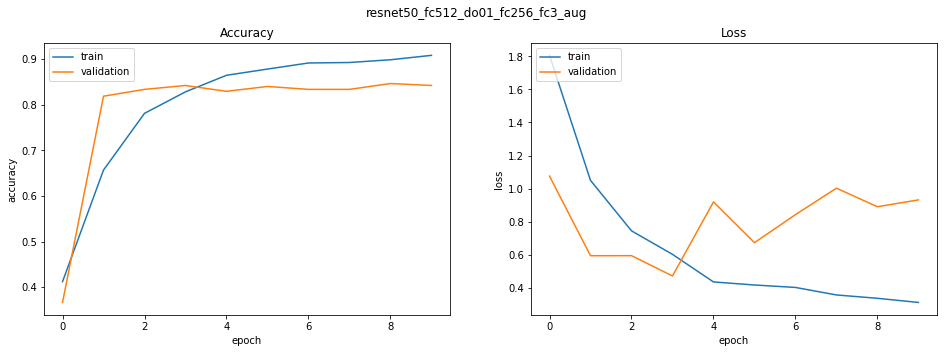

In [7]:
''' Training and Display result'''

# create model architecture
model = tf.keras.models.Sequential([
                                resnet,
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(512, activation='relu'),
                                tf.keras.layers.Dropout(0.1),
                                tf.keras.layers.Dense(256, activation='relu'),
                                tf.keras.layers.Dense(3, activation='softmax')
])

# compile
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
los = tf.keras.losses.categorical_crossentropy
model.compile( optimizer = opt , loss = los , metrics = ['accuracy'] )

# Training
model.fit(
    
    train_dataset,  # both data and label cause we use preprocessing
    validation_data=valid_dataset,
    batch_size=256,
    epochs=10, ### can be change
    shuffle=True 
)

# Plot the result
fig, axs = plt.subplots(1,2, figsize=(16,5))
fig.suptitle(f"{Detail_model}")
axs[0].plot(model.history.history['accuracy'])
axs[0].plot(model.history.history['val_accuracy'])
axs[0].set_title('Accuracy')
axs[0].legend(['train', 'validation'], loc='upper left')
axs[0].set(xlabel='epoch', ylabel='accuracy')

axs[1].plot(model.history.history['loss'])
axs[1].plot(model.history.history['val_loss'])
axs[1].set_title('Loss')
axs[1].legend(['train', 'validation'], loc='upper left')
axs[1].set(xlabel='epoch', ylabel='loss')

''' Save the model '''
model.save(f'{CWD}/Model/{Detail_model}')

In [8]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DATASET_DIR,  # test_dataset path
        image_size=IMAGE_RESIZE,  # each image resize
        batch_size=1, 
        label_mode='categorical',
        color_mode='rgb',
        shuffle=True
    )

print(test_dataset.class_names)  # class check
print(test_dataset)

print("\nLoad data Success!!!")

Found 627 files belonging to 3 classes.
['clementine', 'grapefruit', 'orange']
<BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

Load data Success!!!


In [9]:
model.evaluate(test_dataset)

627/627 [==============================] - 81s 129ms/step - loss: 0.9046 - accuracy: 0.8325


[0.9046236872673035, 0.8325358629226685]

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 75,100,547
Trainable params: 51,512,835
Non-trainable params: 23,587,712
___________________________________

In [11]:
# dir_path = f'{CWD}/images/validation/'
# for j in os.listdir(dir_path):
#     for i in os.listdir(dir_path + '/' + j):
#         img = tf.keras.preprocessing.image.load_img(dir_path + '/' +j+'/'+i, target_size=(224,224))
#         plt.imshow(img)
#         plt.show()

#         X= tf.keras.preprocessing.image.img_to_array(img)
#         X= np.expand_dims(X,axis=0)
#         image = np.vstack([X])
#         val = model.predict(image)
#         '''print(val)
#         print(val[0][0])
#         print(val[0][1])
#         print(val[0][2])
#         print(np.argmax(val)) '''

#         if val[0][0] > val[0][1] and val[0][0] > val[0][2] :
#             print('this is Clementine : '+i)
#             if j == 'clementine':
#                 print('Correct')
#             else:
#                 print('incorrect')
            


#         elif val[0][1] > val[0][0] and val[0][1] > val[0][2] :
#             print('this is Grapefruit : '+i)
#             if j == 'grapefruit':
#                 print('Correct')
#             else:
#                 print('incorrect')
           

#         elif val[0][2] > val[0][0] and val[0][2] > val[0][1] :
#             print('this is Orange : '+i)
#             if j == 'orange':
#                 print('Correct')
#             else:
#                 print('incorrect')
            


In [5]:
predict_model = load_model(f'{CWD}/Model/{Detail_model}')

<PIL.Image.Image image mode=RGB size=224x224 at 0x1F5103D9F10>


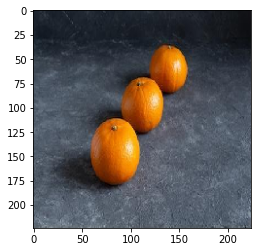

Val : <class 'numpy.float32'>


In [13]:
img = tf.keras.preprocessing.image.load_img(f'{CWD}/images/test/clementine/1000.jpg', target_size=(224,224))
print(img)
plt.imshow(img)
plt.show()

X= tf.keras.preprocessing.image.img_to_array(img)
X= np.expand_dims(X,axis=0)
image = np.vstack([X])
val = predict_model.predict(image)
print("Val : ",end="")
print(type(val[0][0]))